In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd

from nfoursid.kalman import Kalman
from nfoursid.nfoursid import NFourSID
from nfoursid.state_space import StateSpace

warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(2)

In [4]:
NUM_TRAINING_DATAPOINTS = 5000  # create a training-set by simulating a state-space model with this many datapoints
NUM_TEST_DATAPOINTS = 20  # same for the test-set
INPUT_DIM = 3
OUTPUT_DIM = 2
INTERNAL_STATE_DIM = 4  # actual order of the state-space model in the training- and test-set
NOISE_AMPLITUDE = .05  # add noise to the training- and test-set

# define system matrices for the state-space model of the training- and test-set
A = np.array([
    [1,  .01,    0,   0],
    [0,    1,  .01,   0],
    [0,    0,    1, .02],
    [0, -.01,    0,   1],
]) / 1.1
B = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 1],
]
) / 3
C = np.array([
    [1, 0, 1,  1],
    [0, 0, 1, -1],
])
D = np.array([
    [1, 0, 1],
    [0, 1, 0]
]) / 10

In [5]:
state_space = StateSpace(A, B, C, D)
for _ in range(NUM_TRAINING_DATAPOINTS):
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE

    state_space.step(input_state, noise)

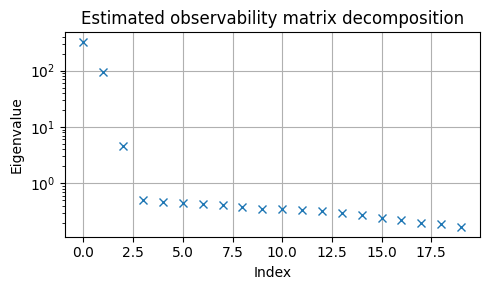

In [6]:
nfoursid = NFourSID(
    state_space.to_dataframe(),  # the state-space model can summarize inputs and outputs as a dataframe
    output_columns=state_space.y_column_names,
    input_columns=state_space.u_column_names,
    num_block_rows=10
)
nfoursid.subspace_identification()

fig, ax = plt.subplots(figsize=(5, 3))
nfoursid.plot_eigenvalues(ax)
fig.tight_layout()

In [7]:
nfoursid = NFourSID(
    state_space.to_dataframe(),  # the state-space model can summarize inputs and outputs as a dataframe
    output_columns=state_space.y_column_names,
    input_columns=state_space.u_column_names,
    num_block_rows=10
)
nfoursid.subspace_identification()

In [8]:
ORDER_OF_MODEL_TO_FIT = 4
state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

In [9]:
np.linalg.norm(state_space_identified.a - A)

np.float64(0.2881138396299479)

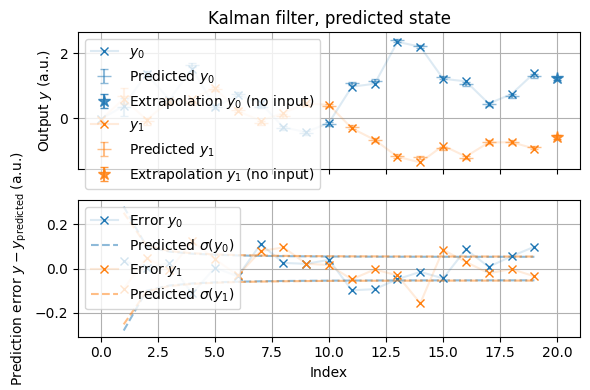

In [10]:
kalman = Kalman(state_space_identified, covariance_matrix)
state_space = StateSpace(A, B, C, D)  # new data for the test-set
for _ in range(NUM_TEST_DATAPOINTS):  # make a test-set
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE
    y = state_space.step(input_state, noise)  # generate test-set
    kalman.step(y, input_state)


fig = plt.figure(figsize=(6, 4))
kalman.plot_predicted(fig)
fig.tight_layout()

In [11]:
kalman.to_dataframe()

$y_0$                                                         \
      actual  filtered                    next predicted (no input)   
      output    output standard deviation                    output   
0  -0.021596 -0.021597           0.073115                  0.108342   
1   0.384157  0.381601           0.072417                  1.408494   
2   1.360613  1.361452           0.068012                  0.289289   
3   0.579168  0.566942           0.064172                  1.850753   
4   1.518399  1.589622           0.061254                  0.301576   
5   0.340228  0.338769           0.059075                  0.866343   
6   0.724461  0.750438           0.057450                  0.426690   
7   0.474126  0.386242           0.056236                 -0.421613   
8  -0.271464 -0.291088           0.055331                 -0.420237   
9  -0.418689 -0.437007           0.054657                 -0.407390   
10 -0.127362 -0.162715           0.054159                  1.210976   
11  0.970444  1.059631           0.053793                  0.929599   
12  1.060103  1.146193           0.053528                  2.299903   
13  2.340905  2.385218           0.053337                  2.314398   
14  2.190810  2.202798           0.053202                  1.293198   
15  1.212483  1.255392           0.053107                  1.006023   
16  1.133706  1.051792           0.053040                  0.492736   
17  0.452570  0.444805           0.052995                  0.704552   
18  0.745942  0.693164           0.052964                  1.314529   
19  1.391322  1.297074           0.052942                  1.223078   

                                                                           \
                      next predicted (input corrected)                      
   standard deviation                           output standard deviation   
0            0.279201                         0.350668           0.279201   
1            0.099986                         1.359510           0.099986   
2            0.076453                         0.553210           0.076453   
3            0.067058                         1.630597           0.067058   
4            0.062115                         0.336163           0.062115   
5            0.059150                         0.759514           0.059150   
6            0.057237                         0.364200           0.057237   
7            0.055948                        -0.297065           0.055948   
8            0.055056                        -0.439939           0.055056   
9            0.054430                        -0.166794           0.054430   
10           0.053987                         1.068416           0.053987   
11           0.053675                         1.152812           0.053675   
12           0.053455                         2.388693           0.053455   
13           0.053301                         2.205880           0.053301   
14           0.053193                         1.256607           0.053193   
15           0.053119                         1.046918           0.053119   
16           0.053069                         0.444707           0.053069   
17           0.053034                         0.690514           0.053034   
18           0.053011                         1.292882           0.053011   
19           0.052995                              NaN           0.052995   

       $y_1$                                                         \
      actual  filtered                    next predicted (no input)   
      output    output standard deviation                    output   
0  -0.032408 -0.032422           0.075024                  0.589823   
1   0.598961  0.604154           0.074083                  0.060527   
2  -0.037185 -0.050411           0.069829                  0.551671   
3   0.520014  0.524468           0.065968                  0.543996   
4   0.602336  0.525270           0.062972                  0.743618   
5   0.934877  0.905472           